In [1]:
from sklearn.cluster import Birch
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [9]:
#The functions provide Gaussian smoothing and scaling for 16 S fraction high resolution repli-seq. The input is a 16 row array aranged from S1 to S16.


def gausssmoothing (rawcoveragematrix,shape=(3,3),sigma=1):
    def gaussfilt2D(shape=shape,sigma=sigma):
        m,n=[(edge-1)/2 for edge in shape]
        y,x = np.ogrid[-m:m+1,-n:n+1]
        array=np.exp(-(x*x+y*y)/(2*sigma*sigma))
        array[array<np.finfo(array.dtype).eps * array.max()] =0
        sumarray=array.sum()
        if sumarray !=0:
            array/=sumarray
        return array
    avmatrix=np.zeros_like(rawcoveragematrix)

    paddedrawcoveragematrix=np.concatenate((np.array([rawcoveragematrix[2,:] for i in range(int((shape[0]-1)/2))]),rawcoveragematrix,np.array([rawcoveragematrix[-1,:] for i in range(int((shape[0]-1)/2))])))
    paddedrawcoveragematrix=np.pad(paddedrawcoveragematrix,((0,0),(int((shape[0]-1)/2),int((shape[0]-1)/2))),'constant',constant_values=np.nan)
    for i in range(int((shape[0]-1)/2),int(len(rawcoveragematrix)+(shape[0]-1)/2)):
        #print (i,'i')
        for j in range(int((shape[0]-1)/2),int(len(rawcoveragematrix[0])+(shape[0]-1)/2)):
            box=np.ma.masked_invalid(paddedrawcoveragematrix[int(i-(shape[0]-1)/2):int(i+(shape[0]-1)/2+1),int(j-(shape[0]-1)/2):int(j+(shape[0]-1)/2+1)])
            
            avmatrix[int(i-(shape[0]-1)/2),int(j-(shape[0]-1)/2)] = np.nansum(np.multiply(box,gaussfilt2D()))
    return (avmatrix)


def scalingto100range(input):
    a_scaled=np.zeros_like(input)
    for i in range(0,len(input)):
        for j in range (len(input[i])):
            a_scaled[i][j]=(input[i][j]/np.sum(input[:,j]))*100
    a_scaled=np.nan_to_num(a_scaled)
    return (a_scaled)

In [10]:
m=np.loadtxt("data/50kb/H1.matrix")
m=np.transpose(m)

In [11]:
m2=gausssmoothing(m)
m3=scalingto100range(m2)

/usr0/home/yuchuanw/anaconda3/envs/model/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


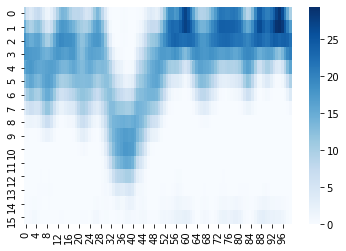

In [12]:
p1 = sns.heatmap(m[:,800:900], cmap='Blues')

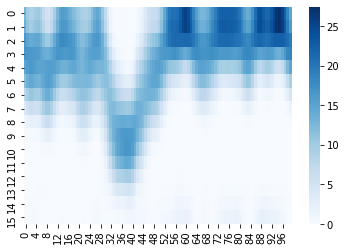

In [13]:
p3 = sns.heatmap(m3[:,800:900], cmap='Blues')

In [36]:
n=80
brc = Birch(n_clusters=n)
brc.fit(np.transpose(m3))
label=brc.predict(np.transpose(m3))

In [37]:
means=np.zeros(shape=(16,n))
for i in range(n):
    tmp=m3[:,brc.labels_==i]
    tmp1=tmp.mean(axis=1)
    means[:,i]=tmp1

In [38]:
np.savetxt("H1.mean.birch_"+str(n)+".mat", np.transpose(means), fmt='%.8e', delimiter='\t')

In [39]:
!./run_sort.sh H1.mean.birch_80.mat H1.birch.index

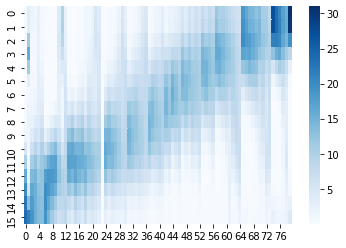

In [40]:
index=np.loadtxt("H1.birch.index")
index=np.array(index[:,0]-1).astype('int')
p_mean = sns.heatmap(means[:,index], cmap='Blues')

# function

In [ ]:
def getbirth(cell,n_cluster=80):
    
    m=np.loadtxt("data/50kb/" + cell + ".matrix")
    m1=np.transpose(m)
    m2=gausssmoothing(m1)
    m3=scalingto100range(m2)
    
    brc = Birch(n_clusters=n_cluster)
    brc.fit(np.transpose(m3))
    
    means=np.zeros(shape=(16,n_cluster))
    for i in range(n_cluster):
        tmp=m3[:,brc.labels_==i]
        tmp1=tmp.mean(axis=1)
        means[:,i]=tmp1
        
    np.savetxt(cell+".mean.birch_" + str(n_cluster) + ".mat", np.transpose(means), fmt='%.8e', delimiter='\t')
    np.savetxt(cell+".mean.birch_" + str(n_cluster) + ".label", brc.labels_, fmt='%d', delimiter='\t')